In [20]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("light")

In [21]:
class GuidewireExperiment:
    def __init__(self, positions):
        self.positions = positions
        self.timesteps = len(positions)

    def get_sphere_position(self, idx):
        sphere_pos = np.array([np.array([
            self.positions[str(i)]["sphere"][str(idx)]["x"], 
            self.positions[str(i)]["sphere"][str(idx)]["y"], 
            self.positions[str(i)]["sphere"][str(idx)]["z"]]) for i in range(0, self.timesteps)])
        return sphere_pos - sphere_pos[0]

    def get_total_time(self):
        total_time = [self.positions[str(i)]["totalTime"] for i in range(0, self.timesteps)]
        return total_time
    
    def get_elapsed_time(self):
        elapsed_time = [self.positions["0"]["elapsedMilliseconds"]]
        for i in range(1,self.timesteps):
            elapsed_time.append(elapsed_time[-1]+self.positions[str(i)]["elapsedMilliseconds"])
        # elapsed_time = [self.positions[str(i)]["elapsedMilliseconds"] for i in range(0, self.timesteps)]
        return np.array(elapsed_time)
    
    def get_delta(self):
        delta = np.array([self.positions[str(i)]["delta"] for i in range(0, self.timesteps)])
        return delta 
    
    def plot_sphere(self, idx, axis=0):
        sphere_pos = self.get_sphere_position(idx)
        
        plt.figure(figsize=(5,5), dpi=70)
        plt.plot(sphere_pos[:,axis])
        plt.xlabel("Timestep")
        plt.ylabel("Position [m]")
        plt.show()
        
    def plot_all_spheres(self, axis=0):
        num_spheres = len(self.positions["0"]["sphere"])
        sphere_matrix = np.array([self.get_sphere_position(i) for i in range(0, num_spheres)])[:,:,axis]
        #sphere_matrix -= np.min(sphere_matrix)
        
        plt.figure(figsize=(6,5), dpi=70)
        plt.imshow(sphere_matrix, aspect="auto", cmap="turbo")
        plt.xlabel("Timestep")
        plt.ylabel("Sphere Index")
        plt.colorbar(label="Position [m]")
        plt.show()

    def plot_experiment(self):
        fig,ax = plt.subplots(3,1, figsize=(7,7), dpi=70)
        time_array = self.get_elapsed_time()/1000
        sphere_pos = self.get_sphere_position(29)
        ax[0].plot(time_array, self.get_total_time())
        ax[0].set_title("Total Time")
        ax[0].set_ylabel("In-Game Time [s]")
        ax[1].plot(time_array, sphere_pos[:,2])
        ax[1].set_title("Last Sphere Displacement")
        ax[1].set_ylabel("Displacement [m]")
        ax[2].plot(time_array, self.get_delta())
        ax[2].set_title("Simulation Error")
        ax[2].set_ylabel("Delta [a.u.]")
        plt.tight_layout()
        plt.show()


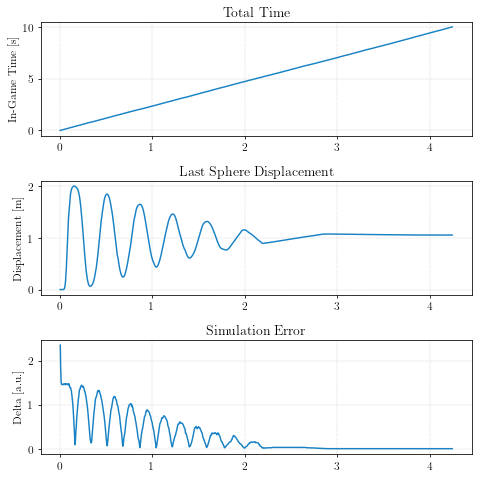

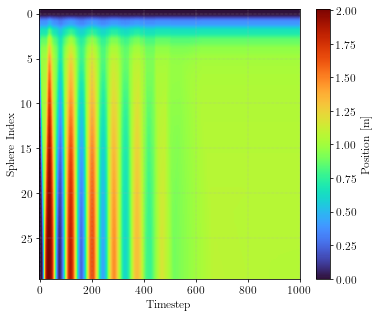

In [32]:
positions = read_json_file("/home/max/Temp/Praktikum/experiments/time_steps/time_steps_0.01/positions.json")

experiment1 = GuidewireExperiment(positions)

experiment1.plot_experiment()
experiment1.plot_all_spheres(axis=2)

# Peak Detection

In [15]:
import numpy as np
from scipy import signal

xs = np.arange(0, experiment1.timesteps)

data = experiment1.get_sphere_position(29)[:,2]

peakind,_ = signal.find_peaks(data)#, np.arange(10,100))

peakind, xs[peakind], data[peakind]

(array([ 48, 148, 249, 350, 452, 554, 656, 758, 867, 975]),
 array([ 48, 148, 249, 350, 452, 554, 656, 758, 867, 975]),
 array([4.00035, 3.81685, 3.55322, 3.30966, 3.04699, 2.8426 , 2.64331,
        2.46952, 2.29557, 2.11735]))

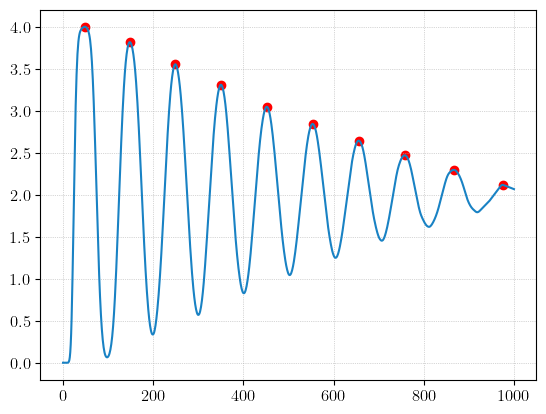

In [16]:
plt.plot(xs, data)
plt.scatter(xs[peakind], data[peakind], c="red")
plt.show()

# Find Relaxation Time

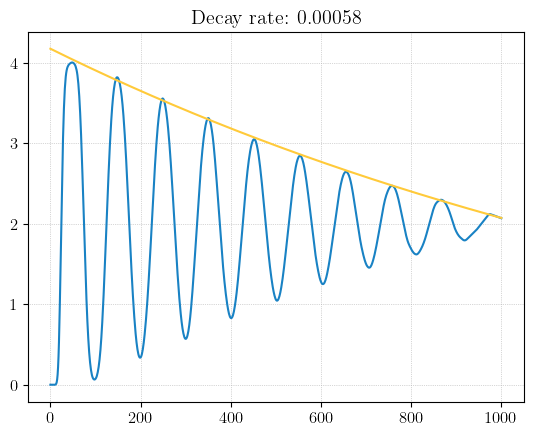

In [19]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a*np.exp(-b*(x-c))+d

peaks_positions = xs[peakind]
peaks_values = data[peakind]

popt, pcov = curve_fit(func, peaks_positions, peaks_values, p0=[1, 0.01, 0, 0])

plt.title(f"Decay rate: {popt[1]:.5f}")
plt.plot(xs, data, label="Data")
plt.plot(xs, func(xs, *popt), label="Fitted Curve")
plt.show()
